<a href="https://colab.research.google.com/github/zuti666/generative-models/blob/master/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Lecture 7 (2018):   Feature Extraction

# Info GAN

## 论文
[[1606.03657\] InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets (arxiv.org)](https://arxiv.org/abs/1606.03657)



## 主要思想

## Info GAN 要处理的问题

input 和 output 不同维度上没有什么关系，不是简单的确定关系

![image-20231004181426978](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004181427.png)

## Info GAN 是什么

![image-20231004181819014](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004181819.png)

c 的维度代表某些特征
generator和discriminator的对抗学习，它的目标其实是得到一个与real data分布一致的fake data分布。

但是由于generator的输入是一个连续的噪声信号，并且没有任何约束，导致GAN将z的具体维度与output的语义特征对应起来，可解释性很差。

它的原理很简单，在info GAN里面，把输入向量z分成两部分，c和z'。c可以理解为可解释的隐变量，而z可以理解为不可压缩的噪声。希望通过约束c与output的关系，使得c的维度对应output的语义特征，以手写数字为例，比如笔画粗细，倾斜度等。

为了引入c，作者通过互信息的方式来对c进行约束，也可以理解成自编码的过程。具体的操作是，generator的output，经过一个分类器，看是否能够得到c。其实可以看成一个anto-encoder的反过程。其余的discriminator与常规的GAN是一样的。

为什么info GAN是有效的，直观的理解就是，如果c的每一个维度对Output都有明确的影响，那么classifier就可以根据x返回原来的c。如果c对output没有明显的影响，那么classifier也没法返回原来的c。

## 公式

![image-20231006202100728](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006202100.png)

相比起原始的GAN，多了一项
 ,这一项代表的就是c与generator的output的互信息。这一项越大，表示c与output越相关。
![image-20231006205416967](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006205423.png)



![image-20231006205720267](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006205720.png)


![image-20231006200407995](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006200408.png)



## 代码


加载库和数据集

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader
import tensorflow as tf
import scipy.ndimage

# 定义超参数
mb_size = 32
Z_dim = 16
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate


# 数据转换和加载
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
X_train = train_images
X_train = X_train.reshape(-1, 28*28)

11490434/11490434 [==============================] - 0s 0us/step


定义网络

In [ ]:
# 初始化权重函数
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

""" ==================== GENERATOR ======================== """

# 生成器模型定义
Wzh = xavier_init(size=[Z_dim + 10, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.ReLU()(torch.mm(inputs, Wzh) + bzh.repeat(inputs.size(0), 1))
    X = nn.Sigmoid()(torch.mm(h, Whx) + bhx.repeat(h.size(0), 1))
    return X

""" ==================== DISCRIMINATOR ======================== """

# 判别器模型定义
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D(X):
    h = nn.ReLU()(torch.mm(X, Wxh) + bxh.repeat(X.size(0), 1))
    y = nn.Sigmoid()(torch.mm(h, Why) + bhy.repeat(h.size(0), 1))
    return y

""" ====================== Q(c|X) ========================== """

# Q 网络模型定义
Wqxh = xavier_init(size=[X_dim, h_dim])
bqxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whc = xavier_init(size=[h_dim, 10])
bhc = Variable(torch.zeros(10), requires_grad=True)

def Q(X):
    h = nn.ReLU()(torch.mm(X, Wqxh) + bqxh.repeat(X.size(0), 1))
    c = nn.Softmax(dim=1)(torch.mm(h, Whc) + bhc.repeat(h.size(0), 1))
    return c

G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
Q_params = [Wqxh, bqxh, Whc, bhc]
params = G_params + D_params + Q_params

训练

Iter-0; D_loss: 15.165328979492188; G_loss: 2.303023338317871; Idx: 1


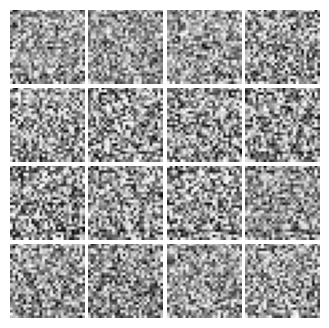

Iter-1000; D_loss: 0.14894814789295197; G_loss: 2.043644428253174; Idx: 5


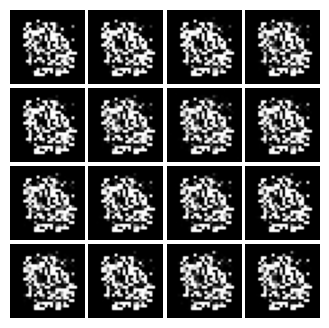

KeyboardInterrupt: ignored

In [ ]:
""" ===================== TRAINING ======================== """

# 重置梯度函数
def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)
Q_solver = optim.Adam(G_params + Q_params, lr=1e-3)

# 采样隐变量 c 的函数
def sample_c(size):
    c = np.random.multinomial(1, 10*[0.1], size=size)
    c = Variable(torch.from_numpy(c.astype('float32')))
    return c
# 采样函数
def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))
for it in range(100000):
    # 采样数据

    X = sample_x(X_train, mb_size)
    X = X.float()  # 将输入数据类型转换为 FloatTensor

    z = Variable(torch.randn(mb_size, Z_dim))
    c = sample_c(mb_size)

    # 判别器前向-损失-反向传播-更新
    G_sample = G(z, c)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss = -torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))

    D_loss.backward()
    D_solver.step()

    # 重置梯度
    reset_grad()

    # 生成器前向-损失-反向传播-更新
    G_sample = G(z, c)
    D_fake = D(G_sample)

    G_loss = -torch.mean(torch.log(D_fake + 1e-8))

    G_loss.backward()
    G_solver.step()

    # 重置梯度
    reset_grad()

    # Q 前向-损失-反向传播-更新
    G_sample = G(z, c)
    Q_c_given_x = Q(G_sample)

    crossent_loss = torch.mean(-torch.sum(c * torch.log(Q_c_given_x + 1e-8), dim=1))
    mi_loss = crossent_loss

    mi_loss.backward()
    Q_solver.step()

    # 重置梯度
    reset_grad()

    # 每隔一段时间打印和绘图
    if it % 1000 == 0:
        idx = np.random.randint(0, 10)
        c = np.zeros([mb_size, 10])
        c[range(mb_size), idx] = 1
        c = Variable(torch.from_numpy(c.astype('float32')))
        samples = G(z, c).data.numpy()[:16]

        print('Iter-{}; D_loss: {}; G_loss: {}; Idx: {}'
              .format(it, D_loss.data.numpy(), G_loss.data.numpy(), idx))

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)

# VAE **GAN**

## 论文
[Autoencoding beyond pixels using a learned similarity metric (mlr.press)](http://proceedings.mlr.press/v48/larsen16)

## 主要思想
![image-20231004182527526](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004182527.png)
![image-20231006210220678](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006210220.png)
![network_outline.png](https://github.com/timsainb/Tensorflow-MultiGPU-VAE-GAN/blob/master/network_outline.png?raw=true)
## How does a VAE-GAN work?

- We have three networks, an  <font color="#38761d"><strong>Encoder</strong></font>,
a <font color="#1155cc"><strong>Generator</strong></font>, and a <font color="#ff0000"><strong>Discriminator</strong></font>.
    - The <font color="#38761d"><strong>Encoder</strong></font> learns to map input x onto z space (latent space)
    - The <font color="#1155cc"><strong>Generator</strong></font> learns to generate x from z space
    - The <font color="#ff0000"><strong>Discriminator</strong></font> learns to discriminate whether the image being put in is real, or generated



## 公式
![image-20231006210354131](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006210354.png)

![image-20231006210511349](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006210511.png)

![image-20231006210532347](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006210532.png)

![image-20231006210233830](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006210233.png)

## 算法流程
![image-20231004182949821](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004182949.png)
![image-20231006210246984](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006210247.png)


## 代码

https://github.com/timsainb/Tensorflow-MultiGPU-VAE-GAN

# ALi GAN /BiGAN

## 论文

[[BiGAN\] Adversarial Feature Learning (arxiv.org)](https://arxiv.org/abs/1605.09782)

## 主要思想

![image-20231004183116691](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004183116.png)

![image-20231004183523389](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004183523.png)

### 只learn d/e 与学习 autoencodeer 有什么区别

![image-20231004183752725](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004183752.png)


encoder 和 decoder 联手骗过 Discrimniator

![image-20231004184624047](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004184624.png)


## 公式
![image-20231007114039761](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231007114039.png)

![image-20231004184644231](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004184644.png)

## 算法流程
###

![image-20231004183351746](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004183351.png)

## 代码


加载库

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader
import tensorflow as tf
import scipy.ndimage
from itertools import chain


# 定义超参数
mb_size = 32
z_dim = 10
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate


# 数据转换和加载
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
X_train = train_images
X_train = X_train.reshape(-1, 28*28)

定义函数

In [ ]:
# Inference net (Encoder) Q(z|X)
Q = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, z_dim)
)

# Generator net (Decoder) P(X|z)
P = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D_ = torch.nn.Sequential(
    torch.nn.Linear(X_dim + z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)


def D(X, z):
    return D_(torch.cat([X, z], 1))


def reset_grad():
    Q.zero_grad()
    P.zero_grad()
    D_.zero_grad()


G_solver = optim.Adam(chain(Q.parameters(), P.parameters()), lr=lr)
D_solver = optim.Adam(D_.parameters(), lr=lr)

训练

Iter-0; D_loss: 6.706e-08; G_loss: 34.84


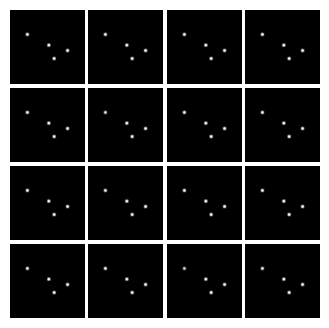

KeyboardInterrupt: ignored

In [ ]:
def log(x):
    return torch.log(x + 1e-8)
# 采样函数
def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))

for it in range(1000000):
    # 采样数据

    X = sample_x(X_train, mb_size)
    X = X.float()  # 将输入数据类型转换为 FloatTensor

    z = Variable(torch.randn(mb_size, z_dim))

    # Discriminator
    z_hat = Q(X)
    X_hat = P(z)

    D_enc = D(X, z_hat)
    D_gen = D(X_hat, z)

    D_loss = -torch.mean(log(D_enc) + log(1 - D_gen))

    D_loss.backward()
    D_solver.step()
    G_solver.step()
    reset_grad()

    # Autoencoder Q, P
    z_hat = Q(X)
    X_hat = P(z)

    D_enc = D(X, z_hat)
    D_gen = D(X_hat, z)

    G_loss = -torch.mean(log(D_gen) + log(1 - D_enc))

    G_loss.backward()
    G_solver.step()
    reset_grad()


    # 每隔一段时间打印和绘图
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'.format(it, D_loss.item(), G_loss.item()))

        samples = P(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)


# Triple GAN

## 论文
[Triple Generative Adversarial Nets (neurips.cc)](https://proceedings.neurips.cc/paper_files/paper/2017/hash/86e78499eeb33fb9cac16b7555b50767-Abstract.html)

## 主要思想

少量label data ,大量 unlabel data , semi-supervised learning

目标是学习一个好的 classifier
![image-20231004190037023](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004190037.png)

## 公式

![image-20231007120048135](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231007120048.png)

![image-20231007120108874](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231007120108.png)

![image-20231007120536075](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231007120536.png)




## 算法步骤
![image-20231004190207829](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004190207.png)

## 代码


库和数据集

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

# Set random seed for reproducibility
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

# Define global variables
batch_size = 32

noise_dim = 10
class_num = 10
num_epochs = 100
l2_norm_lambda = 0.001
alpha_P = 0.5
alpha_pseudo = 0.1
alpha_apply_thr = 200
keep_prob_rate = 0.5
out_image_dir = './out_images_tripleGAN'
out_model_dir = './out_models_tripleGAN'

# Create output directories
import os
os.makedirs(out_image_dir, exist_ok=True)
os.makedirs(out_model_dir, exist_ok=True)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


G,D

In [ ]:
# Define the generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(class_num + noise_dim, 64)
        self.bn1 = nn.BatchNorm1d( 64)
        self.fc2 = nn.Linear( 64,  64)
        self.bn2 = nn.BatchNorm1d( 64)
        self.fc3 = nn.Linear( 64,  64)
        self.bn3 = nn.BatchNorm1d( 64)
        self.fc4 = nn.Linear( 64, 784)

    def forward(self, y, z):
        x = torch.cat([y, z], dim=1)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))
        x = x.view(x.size(0), 1, 28, 28)
        return x, y

# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(794, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 250)
        self.fc5 = nn.Linear(250, 250)
        self.fc6 = nn.Linear(250, 1)

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        x = torch.cat([x, y], dim=1)
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = torch.nn.functional.leaky_relu(self.fc3(x), negative_slope=0.2)
        x = torch.nn.functional.leaky_relu(self.fc4(x), negative_slope=0.2)
        x = torch.nn.functional.leaky_relu(self.fc5(x), negative_slope=0.2)
        x = torch.sigmoid(self.fc6(x))
        return x

# Define the classifier model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x, keep_prob):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = nn.functional.dropout(x, p=keep_prob)
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = nn.functional.dropout(x, p=keep_prob)
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.mean(x.view(x.size(0), -1), dim=1)
        x = self.fc6(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

# Initialize models
generator = Generator()
discriminator = Discriminator()
classifier = Classifier()

# Create optimizers
optimizer_gen = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_dis = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_cla = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.5, 0.999))


In [ ]:
# Define loss functions
criterion_gen = nn.MSELoss()
criterion_dis = nn.MSELoss()
criterion_cla = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        # Get real data and labels
        real_data, labels = data
        real_data, labels = real_data.float(), labels.float()

        # Create noise vectors
        noise = torch.randn(batch_size, noise_dim)

        # Generate fake data and labels
        fake_labels = torch.randint(0, class_num, (batch_size,noise_dim)).float()

        # 输出查看维度
        print(fake_labels.shape)
        print(noise.shape)

        fake_data, _ = generator(fake_labels, noise)

        # Discriminator forward pass
        real_data_pred = discriminator(real_data, labels)
        fake_data_pred = discriminator(fake_data.detach(), fake_labels)

        # Calculate discriminator loss
        loss_dis_real = criterion_dis(real_data_pred, torch.ones_like(real_data_pred))
        loss_dis_fake = criterion_dis(fake_data_pred, torch.zeros_like(fake_data_pred))
        loss_dis = loss_dis_real + loss_dis_fake

        # Discriminator backward pass and optimization
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()

        # Generate new fake data and labels
        fake_labels = torch.randint(0, class_num, (batch_size,))
        fake_data, _ = generator(fake_labels.float(), noise)

        # Classifier forward pass
        classifier_pred = classifier(real_data, keep_prob_rate)

        # Calculate classifier loss
        loss_cla = criterion_cla(classifier_pred, labels)

        # Classifier backward pass and optimization
        optimizer_cla.zero_grad()
        loss_cla.backward()
        optimizer_cla.step()

        # Generator forward pass
        fake_data_pred = discriminator(fake_data, fake_labels.float())

        # Calculate generator loss
        loss_gen = criterion_gen(fake_data_pred, torch.ones_like(fake_data_pred))

        # Generator backward pass and optimization
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        # Print statistics
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(trainloader)}]')
            print(f'Discriminator Loss: {loss_dis.item():.4f}, Generator Loss: {loss_gen.item():.4f}, Classifier Loss: {loss_cla.item():.4f}')

    # Save generated images
    with torch.no_grad():
        noise = torch.randn(64, noise_dim).cuda()
        labels = torch.arange(0, 10).repeat(6).cuda()
        fake_images, _ = generator(labels.float(), noise)
        fake_images = fake_images * 0.5 + 0.5  # Scale to [0, 1]
        save_image(fake_images, os.path.join(out_image_dir, f'epoch_{epoch + 1}.png'), nrow=10, padding=2)

    # Save models
    if (epoch + 1) % 50 == 0:
        torch.save(generator.state_dict(), os.path.join(out_model_dir, f'generator_epoch_{epoch + 1}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(out_model_dir, f'discriminator_epoch_{epoch + 1}.pth'))
        torch.save(classifier.state_dict(), os.path.join(out_model_dir, f'classifier_epoch_{epoch + 1}.pth'))

print('Finished Training')

torch.Size([32, 10])
torch.Size([32, 10])


RuntimeError: ignored

# Domain-adversarial






##  论文
[Domain-adversarial](https://www.jmlr.org/papers/volume17/15-239/15-239.pdf)


## 主要思想

抽取特征

![image-20231004185043528](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004185043.png)

![image-20231004185241798](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004185241.png)

# Feature Disentangle

## 论文
[Speaker-Invariant Training Via Adversarial Learning](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8461932)

Encoder 和 Decodeer 中间抽取的特征并不一定是自己想要的信息，并且不清楚特征对应什么

我们想要对应不同东西对应的特征

![image-20231004185636668](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004185636.png)

### 怎么做—1控制不同特征

![image-20231004185724281](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004185724.png)

### 怎么做 ，2训练一个分类器 GAN的思想

![image-20231004185801904](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004185801.png)